<a href="https://colab.research.google.com/github/tahamsi/computer-vision/blob/main/generative-models/DDIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 [![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/tahamsi/computer-vision)

#Denoising Diffusion Implicit Models (DDIM)

Denoising Diffusion Implicit Models (DDIM) are a class of generative models designed to enhance the efficiency of image generation processes. They build upon Denoising Diffusion Probabilistic Models ([DDPMs](https://github.com/tahamsi/computer-vision/blob/main/generative-models/DDPM.ipynb)), which have demonstrated high-quality image synthesis without the need for adversarial training. However, DDPMs typically require simulating a Markov chain over many steps to produce a sample, leading to slower generation times.

To address this, DDIMs introduce a more efficient class of iterative implicit probabilistic models that maintain the same training procedure as DDPMs but allow for faster sampling. In DDPMs, the generative process is defined as the reverse of a specific Markovian diffusion process. DDIMs generalize this by constructing non-Markovian diffusion processes that lead to the same training objective. This approach enables the reverse process to be much faster during sampling. Empirical studies have shown that DDIMs can produce high-quality samples 10 to 50 times faster in terms of wall-clock time compared to DDPMs.

Additionally, DDIMs allow for trading off computation for sample quality and can perform semantically meaningful image interpolation directly in the latent space ([Song, et al., 2021](https://arxiv.org/pdf/2010.02502)).


##Key Features of DDIM
* Efficient Sampling: DDIMs significantly reduce the number of steps needed during sampling. For example, while DDPMs may require 1000 steps, DDIMs can achieve comparable results with 50–100 steps.
* Deterministic Sampling: Unlike DDPMs, DDIMs don't rely on stochastic noise at each step, leading to more stable and consistent outputs.
* Same Training Procedure: DDIMs maintain the same training process as DDPMs, making it easy to adopt without additional complexity.
* Latent Space Manipulation: DDIMs enable meaningful operations like interpolating between images directly in their latent space, offering new possibilities for creative applications.

## Forward Diffusion Process

In both DDPMs and DDIMs, the forward process progressively adds noise to an image $𝑥_0$ to produce $𝑥_𝑡$ over $𝑇$  time steps:
$$q(x_t \mid x_0) = \mathcal{N}(x_t; \sqrt{\alpha_t} \, x_0, (1 - \alpha_t) \mathbf{I})$$

* $\alpha_t$: A schedule controlling how noise is added at each step $𝑡$.
* $𝑥_𝑡$: The noisy version of the image at step $𝑡$.
* $\mathcal{N}$: Gaussian distribution (noise is added following this distribution).

This forward process produces a series of progressively noisier images, starting from the original data $𝑥_0$ and ending with pure noise $𝑥_𝑇$.

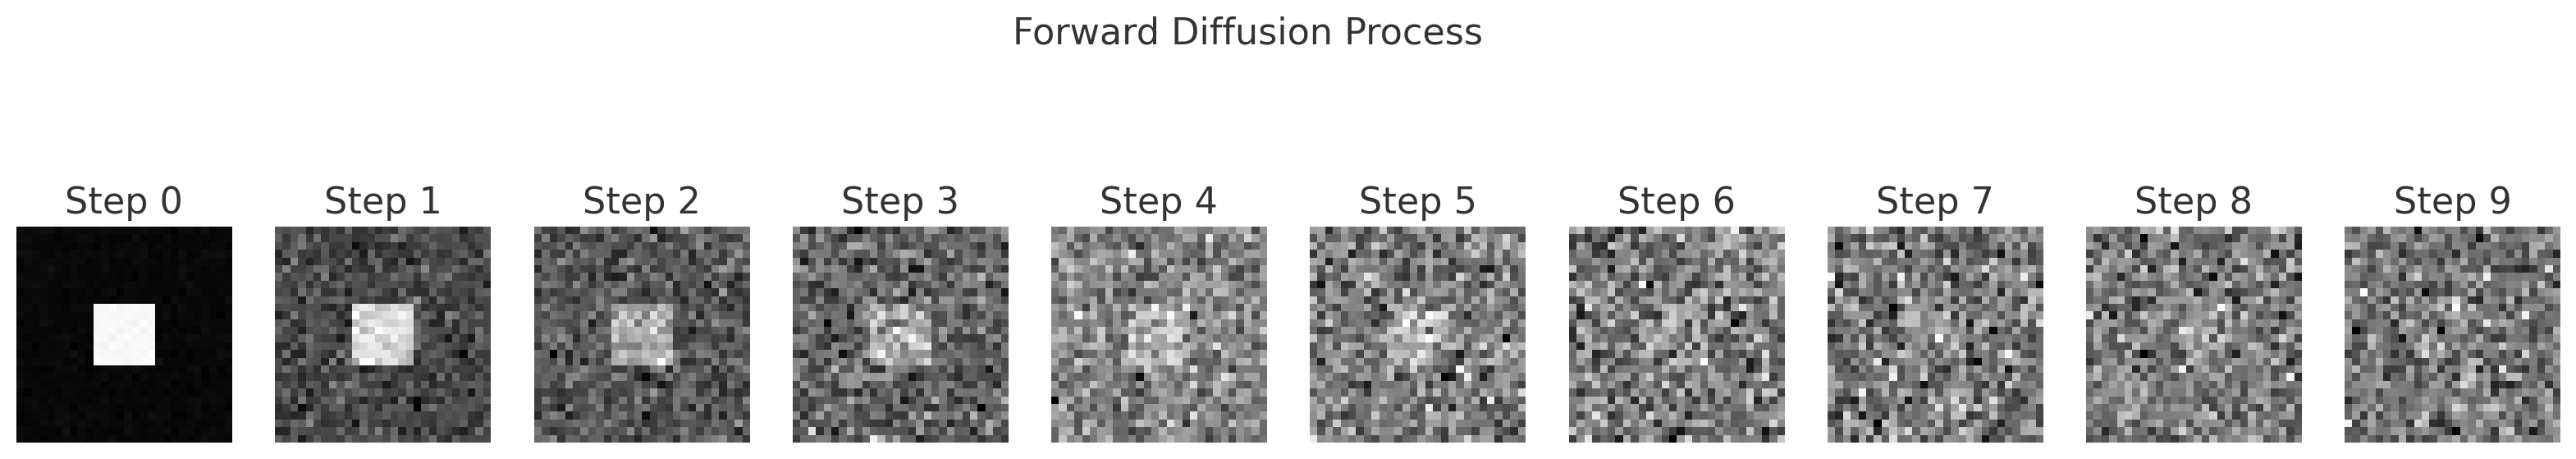

##Reverse Process (Denoising)
The reverse process learns to remove noise step-by-step to recover the original image $𝑥_0$:
$$p_\theta(x_{t-1} \mid x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$$

* $\mu_\theta$: The predicted mean (center of the denoised data).
* $Sigma_\theta$: The variance (uncertainty in denoising).
* $\theta$: Parameters learned by a neural network during training.

In DDPMs, this reverse process involves sampling noise at every step, making it slow.

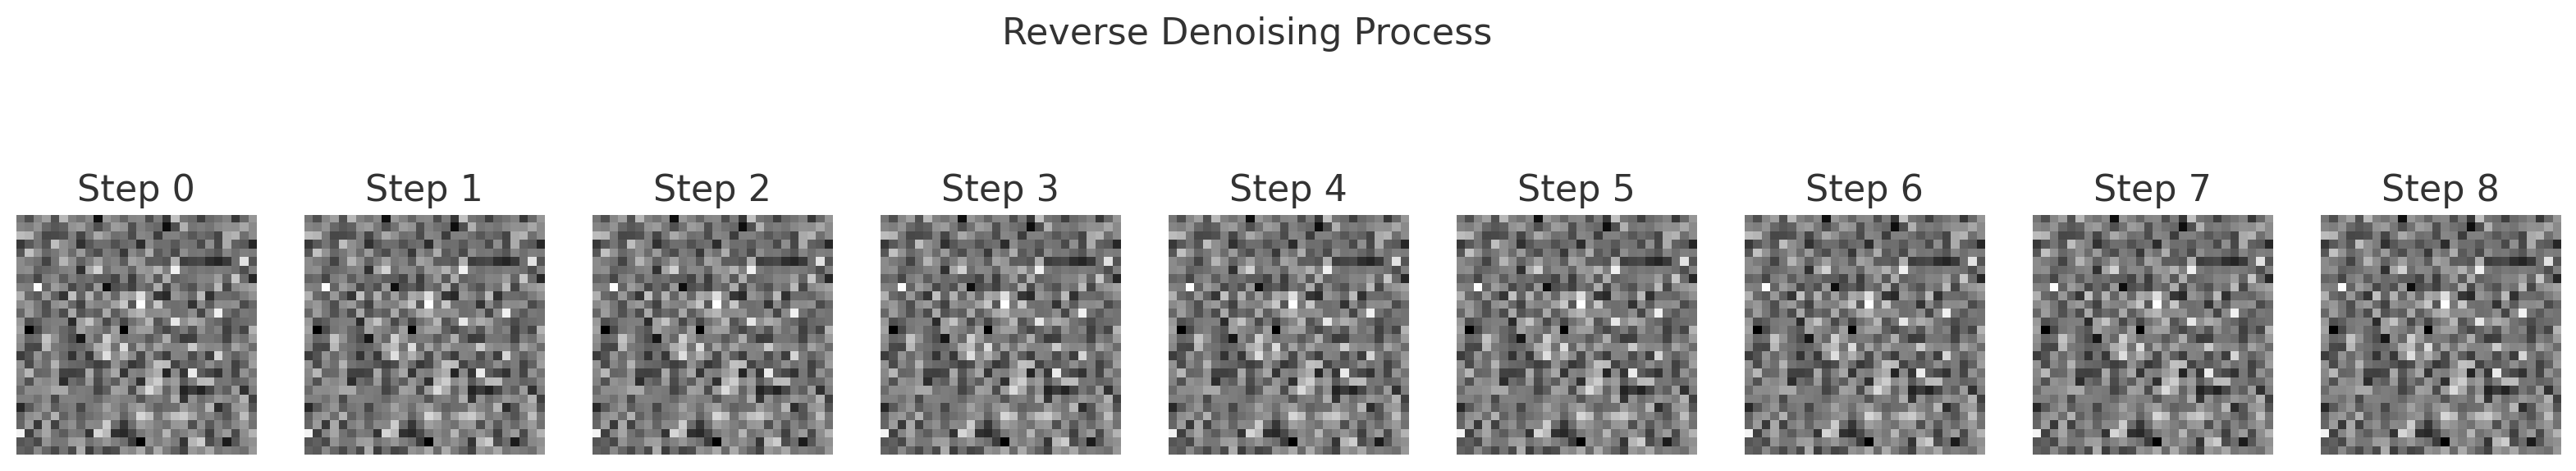

##DDIM’s Deterministic Sampling
DDIM introduces a deterministic version of the reverse process, avoiding random sampling at each step. Instead, it directly computes $𝑥_{𝑡-1}$ from $𝑥_𝑡$:
$$
x_{t-1} = \sqrt{\alpha_{t-1}} \cdot \hat{x}_0(x_t) + \sqrt{1 - \alpha_{t-1}} \cdot \epsilon_t
$$

* $\hat{x}_0(x_t)$: The predicted original image at step $𝑡$, estimated by the neural network.
* $\epsilon_t$: Noise predicted by the neural network.
* $\alpha_{t-1}$: The noise schedule at step $𝑡-1$.

This equation avoids resampling and speeds up the process because; (i) DDIM reuses noise predictions ($\epsilon_t$) from the forward process, (ii) it computes $𝑥_{𝑡−1}$ directly, skipping the stochastic step.

## Loss Function
Instead of directly optimizing the full variational bound, DDIM simplifies this with noise prediction training, similar to DDPMs. The training objective is to predict the noise $ϵ$ added to the data at each time step $𝑡$. This is formulated as:
$$
L_t = \mathbb{E}_{x_0, \epsilon, t} \left[\|\epsilon - \epsilon_\theta(x_t, t)\|^2 \right]
$$
* $x_t$: The noisy data at step $𝑡$, obtained from $𝑞(x_t|𝑥_0).

* $ϵ$: The actual noise added during the forward process.
* $\epsilon_\theta(x_t, t)$: The predicted noise by the model (parameterized by
$\theta$).
* $\|.\|^2$: The squared L2 norm.

## Implementation

####Before you start
Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit -> Notebook settings -> Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

### Setup and Data Preparation
We use `torch` for deep learning, `torchvision` for `MNIST` dataset, and `matplotlib` for visualization.
####Hyperparameters:
* `batch_size`: Number of examples processed together in one pass.
* `data_dim`: Flattened size of each MNIST image (28x28 = 784 pixels).
* `timesteps`: Number of steps in the forward diffusion process.
* `device`: Use GPU if available for faster computation.

####Data Preparation:
* `transforms.Compose`: Converts images to tensors and flattens them into 1D vectors.
* `datasets.MNIST`: Loads the MNIST dataset.
* `DataLoader`: Organizes the dataset into batches and allows shuffling.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 64
data_dim = 28 * 28  # MNIST image size (28x28)
timesteps = 1000  # Number of diffusion steps
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

###Noise Prediction Model
This model predicts the noise $ϵ_θ$ added during the forward diffusion process.

####Structure

* A fully connected feedforward network with three layers, using `ReLU` activation (feel free to change this topology).

* Input dimension is `data_dim` + 1 because the timestep $𝑡$ is concatenated with the image data.
* Output dimension is `data_dim` to match the size of the input data.

####Forward Pass
* $𝑡$: The current diffusion timestep is normalized and repeated to match the shape of $𝑥$.
* Concatenate $𝑡$ with $𝑥$ to form the input for the network.

In [ ]:
class NoisePredictor(nn.Module):
    def __init__(self):
        super(NoisePredictor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(784 + 1, 512),  # Update input size here
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 784)  # Ensure output matches data_dim
        )

    def forward(self, x, t):
        # Concatenate timestep t as an additional input
        t_embed = t.unsqueeze(1).float() / timesteps  # Normalize timestep
        x_t = torch.cat([x, t_embed], dim=1)  # Concatenate x and t
        return self.net(x_t)

###Noise Scheduler
Controls the rate at which noise is added to the data during diffusion.
####Cosine Schedule:
* Produces smooth transitions in $α_t$, improving stability during training.
* $α_t$: Proportional to how much information remains at timestep $𝑡$.

In [ ]:
def cosine_schedule(t):
    s = 0.008
    return torch.cos((t / timesteps + s) / (1 + s) * torch.pi / 2) ** 2

###Diffusion Loss
Forward Diffusion: Noise is added to the clean image $x_0$ using:

$$
x_t = \sqrt{\alpha_t} \cdot x_0 + \sqrt{1 - \alpha_t} \cdot \epsilon
$$


$\epsilon$ is random Gaussian noise.

####Loss Computation:
The model predicts $\epsilon$ added during diffusion. Mean Squared Error (MSE) loss is computed between the true $\epsilon$ and the predicted $\epsilon_θ$.

In [ ]:
def diffusion_loss(model, x_0, t, noise_scheduler):
    # Sample noise
    epsilon = torch.randn_like(x_0).to(device)

    # Forward diffusion (add noise)
    alpha_t = noise_scheduler(t)
    sqrt_alpha_t = torch.sqrt(alpha_t).unsqueeze(1)
    sqrt_one_minus_alpha_t = torch.sqrt(1 - alpha_t).unsqueeze(1)
    x_t = sqrt_alpha_t * x_0 + sqrt_one_minus_alpha_t * epsilon

    # Predict noise
    epsilon_pred = model(x_t, t)

    # Compute MSE loss
    loss = F.mse_loss(epsilon_pred, epsilon)
    return loss

###Training Loop
Trains the model to predict noise accurately for any timestep $𝑡$.

####Steps

* Randomly select a timestep $𝑡$ for each batch.
* Compute the loss using `diffusion_loss`.
* Use backpropagation to update model weights.

####Output
* Prints the loss at the end of each epoch

In [ ]:
# Model, optimizer
model = NoisePredictor().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 5

# Training Loop
for epoch in range(epochs):
    for batch in dataloader:
        x_0 = batch[0].to(device)
        t = torch.randint(0, timesteps, (x_0.size(0),)).to(device)  # Random timesteps

        # Compute loss
        loss = diffusion_loss(model, x_0, t, cosine_schedule)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

###Sampling with Visualization
Performs reverse diffusion to generate images from pure noise.
####Steps
* Start with random noise $𝑥_𝑇$.
* At each step $𝑡$, predict $ϵ_t$ and compute the denoised image $x_{t-1}$.
* Save intermediate steps for visualization.

####Visualization
* Intermediate images show how noise is gradually removed.

In [ ]:
def ddim_sampling_with_visualization(model, x_T, timesteps, noise_scheduler):
    x_t = x_T
    intermediate_steps = []

    for t in reversed(range(1, timesteps)):
        alpha_t = noise_scheduler(torch.tensor([t]).to(x_T.device))
        alpha_t_1 = noise_scheduler(torch.tensor([t - 1]).to(x_T.device))

        sqrt_alpha_t_1 = torch.sqrt(alpha_t_1)
        sqrt_one_minus_alpha_t_1 = torch.sqrt(1 - alpha_t_1)

        epsilon_t = model(x_t, torch.tensor([t] * x_T.size(0)).to(x_T.device))
        x_0_pred = (x_t - torch.sqrt(1 - alpha_t) * epsilon_t) / torch.sqrt(alpha_t)
        x_t_1 = sqrt_alpha_t_1 * x_0_pred + sqrt_one_minus_alpha_t_1 * epsilon_t

        x_t = x_t_1

        # Save intermediate step
        if t % 50 == 0:
            intermediate_steps.append(x_t.cpu().detach())

    return x_t, intermediate_steps

# Generate samples
x_T = torch.randn((16, data_dim)).to(device)  # Start with pure noise
samples, intermediate_steps = ddim_sampling_with_visualization(model, x_T, timesteps, cosine_schedule)

###Visualization
* Intermediate Steps: Shows how the model progressively removes noise.
* Final Samples: Displays the fully denoised images, resembling digits from the MNIST dataset.

In [ ]:
# Visualize denoising process
fig, axes = plt.subplots(1, len(intermediate_steps), figsize=(20, 5))
for i, step in enumerate(intermediate_steps):
    img = step[0].reshape(28, 28).cpu().numpy()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Step {timesteps - i * 50}")
    axes[i].axis('off')
plt.show()

# Final Samples
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples[i].reshape(28, 28).cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle("Generated Samples")
plt.show()